## Weddell Sea surface freshwater budget

In [1]:
import xarray as xr
import numpy as np
import gsw
import cmocean
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import closest_point

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
nemo_mesh= f'{base_dir}bathymetry/mesh_mask-20240305.nc'
run_dir  = f'{base_dir}output/ERA5_test7/'

In [10]:
gridT_files = np.sort(glob.glob(f'{run_dir}files/*grid_T*'))
SBC_files   = np.sort(glob.glob(f'{run_dir}files/*SBC*'))
ice_files   = np.sort(glob.glob(f'{run_dir}files/*icemod*'))

ds_mesh = xr.open_dataset(nemo_mesh).squeeze()
# ds_gridT= xr.open_dataset(gridT_files[0])
# ds_SBC  = xr.open_dataset(SBC_files[0]).rename({'x_grid_T':'x','y_grid_T':'y'})
# ds_ice  = xr.open_dataset(ice_files[0])

In [11]:
# regions:
weddell_overall    = {'x': slice(850, 1200, None), 'y': slice(50, -1, None)}
weddell_shelfbreak = {'x': slice(910, 1190, None), 'y': slice(210, -95, None)}

In [18]:
# ds_SBC  = xr.open_mfdataset(np.append(SBC_files[0:19], SBC_files[20:])).rename({'x_grid_T':'x','y_grid_T':'y'})
ds_T    = xr.open_mfdataset(gridT_files[0:-2]).rename({'x_grid_T':'x','y_grid_T':'y'})

In [13]:
def get_slope_contour(bathy, X, Y, pathno, level=1000):
    # From Michael Haigh
    cs = plt.contour(X, Y, bathy, levels=[level])
    x = cs.collections[0].get_paths()[pathno].vertices[:,0][::-1]
    y = cs.collections[0].get_paths()[pathno].vertices[:,1][::-1]
    plt.clf()

    return x, y

In [14]:
slope_x, slope_y = get_slope_contour(ds_mesh.isel(**weddell_shelfbreak).bathy_metry, 
                                     ds_mesh.isel(**weddell_shelfbreak).nav_lon, ds_mesh.isel(**weddell_shelfbreak).nav_lat, 0, level=1500)

shelfbreak_x = np.array([]).astype(int); shelfbreak_y = np.array([]).astype(int);
for ptx, pty in zip(slope_x, slope_y):
    [y, x] = closest_point(ds_mesh, (ptx, pty))
    shelfbreak_x = np.append(x, shelfbreak_x)
    shelfbreak_y = np.append(y, shelfbreak_y)

<Figure size 432x288 with 0 Axes>

In [19]:
ds_T_shelfbreak = ds_T.isel(x=xr.DataArray(shelfbreak_x, dims='sh'), y=xr.DataArray(shelfbreak_y, dims='sh'))#.isel(time_counter=0)

(100.0, 400.0)

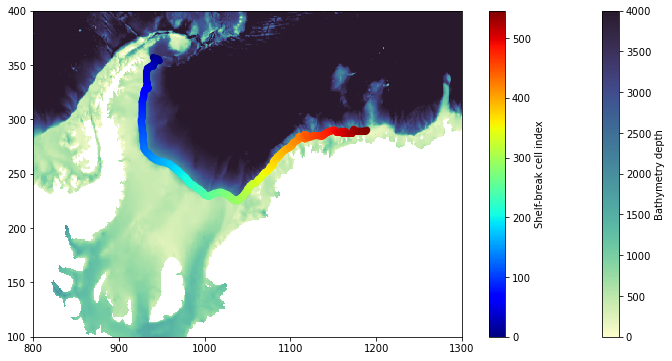

In [219]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
cm1 = ax.pcolormesh(ds_mesh.x, ds_mesh.y, ds_mesh.bathy_metry.where(ds_mesh.bathy_metry!=0), vmin=0, vmax=4000, cmap=cmocean.cm.deep)
cm2 = ax.scatter(shelfbreak_x, shelfbreak_y, c=ds_T_shelfbreak.sh, cmap='jet')
fig.colorbar(cm1, label='Bathymetry depth')
fig.colorbar(cm2, label='Shelf-break cell index')
ax.set_xlim(800, 1300)
ax.set_ylim(100, 400)

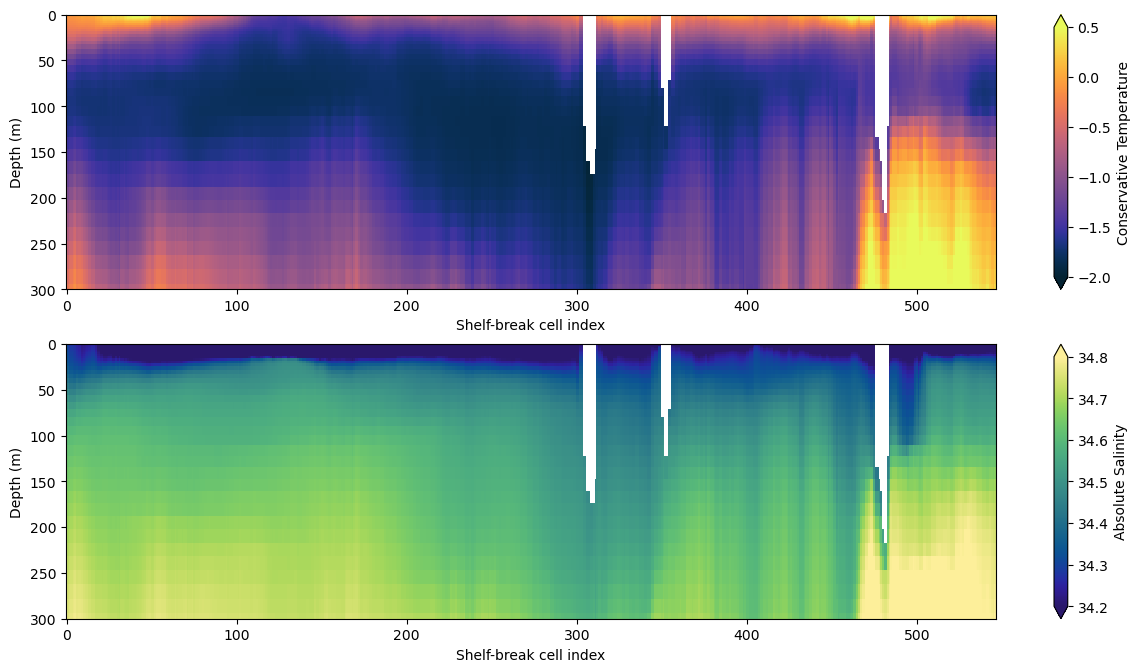

In [220]:
fig, ax = plt.subplots(2,1, figsize=(15,8), dpi=100)
cmT = ax[0].pcolormesh(ds_T_shelfbreak.sh, ds_T_shelfbreak.deptht, ds_T_shelfbreak.thetao.where(ds_T_shelfbreak.thetao!=0), 
                       vmin=-2, vmax=0.5, cmap=cmocean.cm.thermal)
cmS = ax[1].pcolormesh(ds_T_shelfbreak.sh, ds_T_shelfbreak.deptht, ds_T_shelfbreak.so.where(ds_T_shelfbreak.so!=0),
                       vmin=34.2, vmax=34.8, cmap=cmocean.cm.haline)

for axis in ax.ravel():
    axis.set_ylim(300,0)
    axis.set_ylabel('Depth (m)')
    axis.set_xlabel('Shelf-break cell index')

fig.colorbar(cmT, ax=ax[0], label='Conservative Temperature', extend='both')
fig.colorbar(cmS, ax=ax[1], label='Absolute Salinity', extend='both')

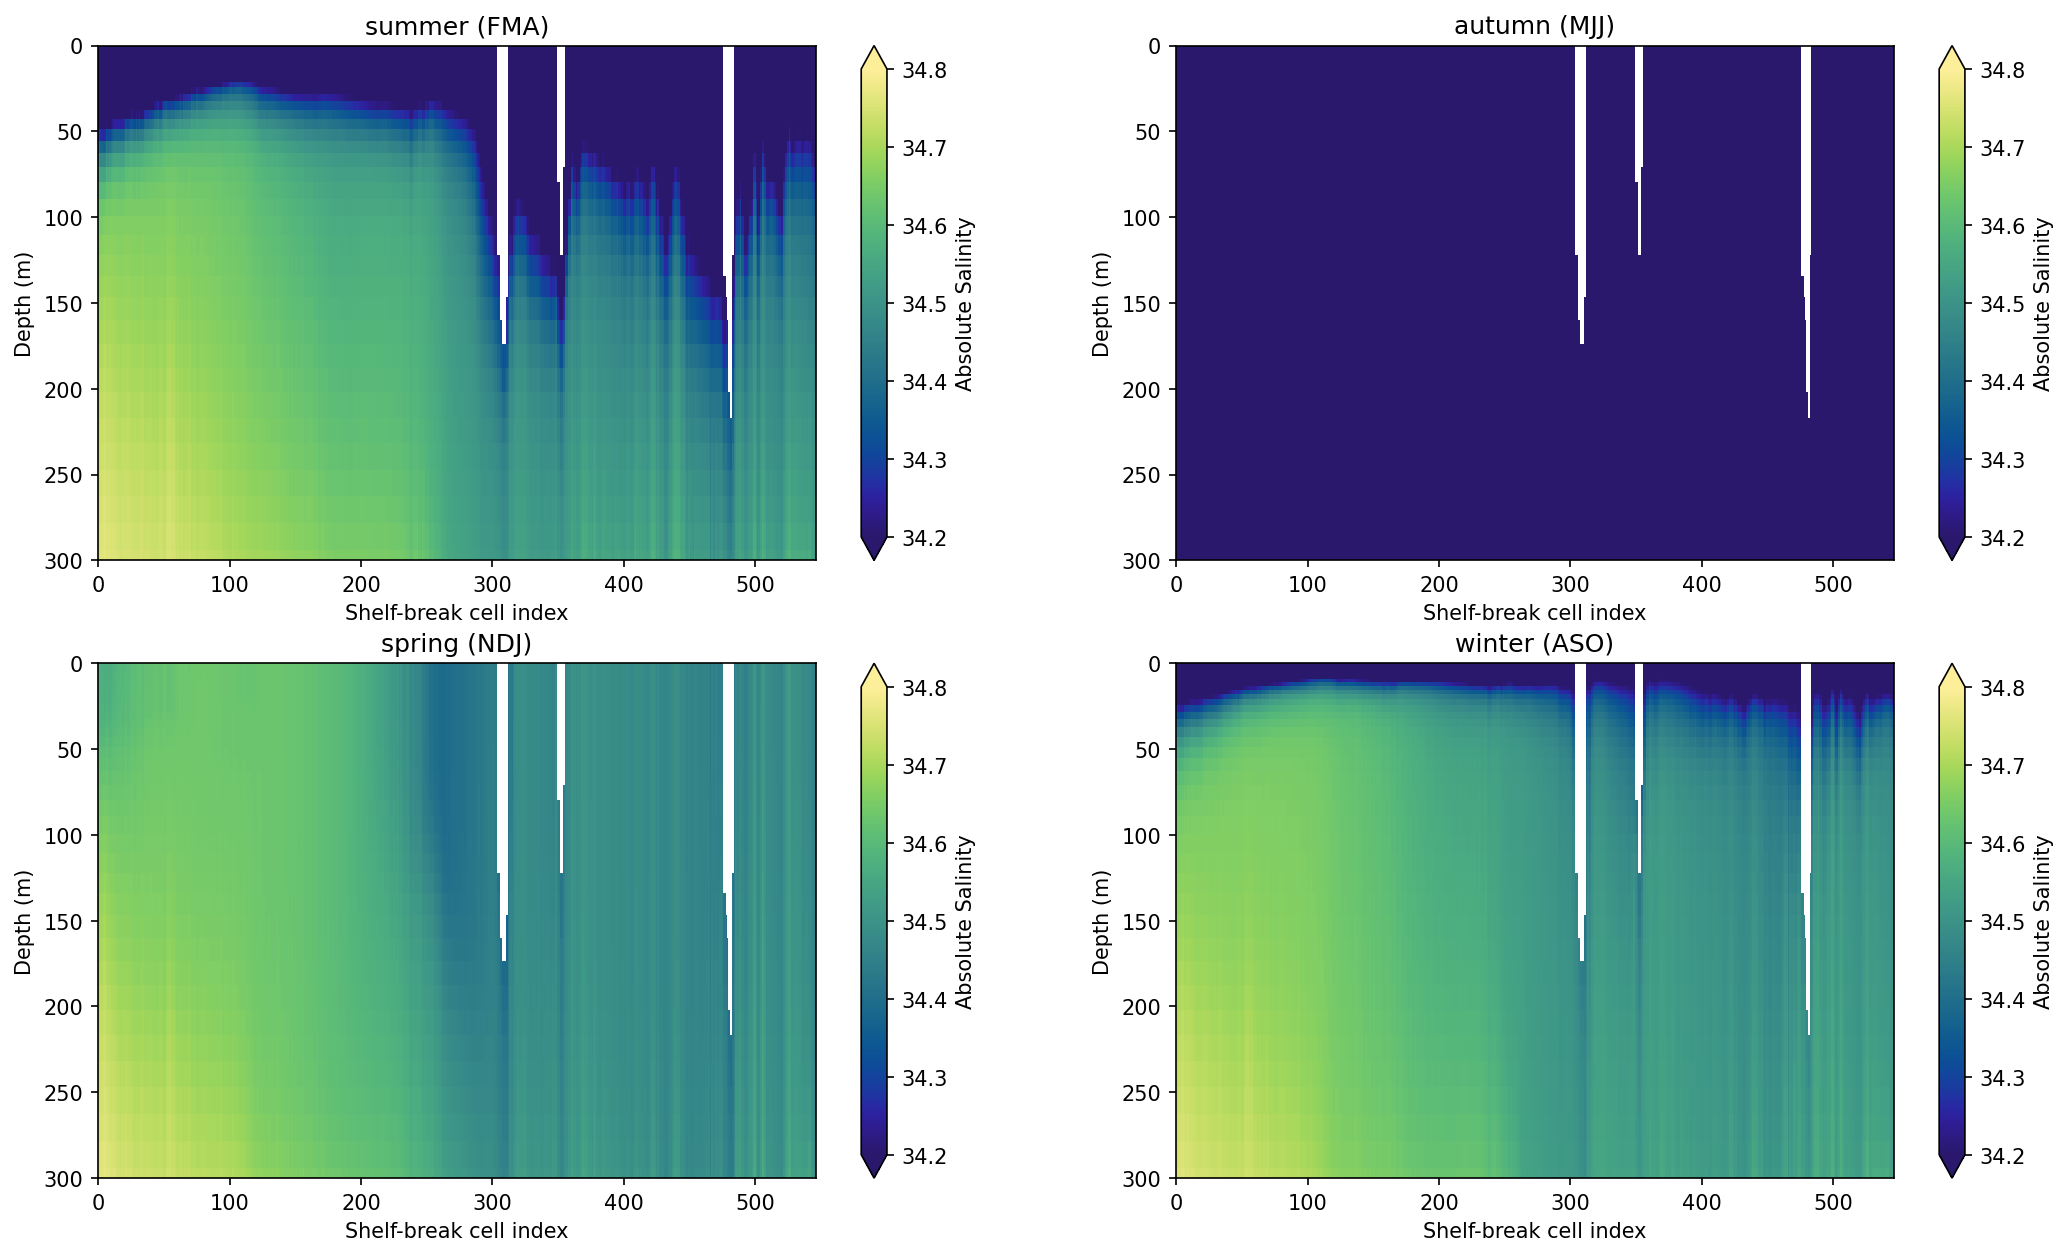

In [20]:
fig, ax = plt.subplots(2,2, figsize=(17,10), dpi=150)

season_months = [[2,3,4], [5,6,7], [8,9,10], [11,12,1]]
season_names  = ['summer (FMA)', 'autumn (MJJ)', 'spring (NDJ)', 'winter (ASO)']

for a, axis in enumerate(ax.ravel()):
    dsT_season = ds_T_shelfbreak.isel(time_counter=ds_T_shelfbreak.time_counter.dt.month.isin(season_months[a])).mean(dim='time_counter', keep_attrs=True)
    axis.set_title(season_names[a])

    cmT = axis.pcolormesh(dsT_season.sh, dsT_season.deptht, dsT_season.so.where(dsT_season.so!=0), 
                       vmin=34.2, vmax=34.8, cmap=cmocean.cm.haline)

    axis.set_ylim(300,0)
    axis.set_ylabel('Depth (m)')
    axis.set_xlabel('Shelf-break cell index')

    fig.colorbar(cmT, ax=axis, label='Absolute Salinity', extend='both')